# B-Spline Trajectory Example

In [1]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    'font.size': 18,
})

np.set_printoptions(6, suppress=True)

from pylgmath import Transformation, se3op
from pysteam.trajectory import Time
from pysteam.trajectory.bspline import Interface as TrajectoryInterface
from pysteam.problem import OptimizationProblem, StaticNoiseModel, L2LossFunc, WeightedLeastSquareCostTerm
from pysteam.solver import GaussNewtonSolver
from pysteam.evaluable import vspace as vspaceev, se3 as se3ev

Begin Optimization
------------------
Number of States:  6
Number of Cost Terms:  9
Initial Cost:  2.8800000000000003
Iteration:    1  -  Cost:     0.0149
Iteration:    2  -  Cost:     0.0149
Termination Cause:  CONVERGED ABSOLUTE CHANGE
Total Optimization Time: 0.0151 seconds


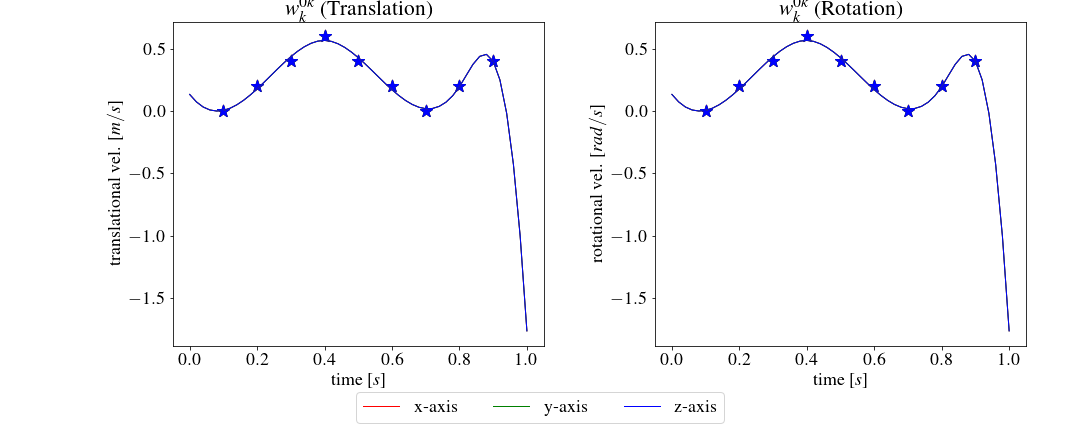

In [2]:
T_TOTAL = 1.0
knot_spacing = Time(secs=0.4)
traj = TrajectoryInterface(knot_spacing)

#
cost_terms = []
loss_func = L2LossFunc()
noise_model = StaticNoiseModel(np.eye(6))

w_iv_inv_meas = []
w_iv_inv_meas.append((0.1 * T_TOTAL, np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T))
w_iv_inv_meas.append((0.2 * T_TOTAL, np.array([[0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]).T))
w_iv_inv_meas.append((0.3 * T_TOTAL, np.array([[0.4, 0.4, 0.4, 0.4, 0.4, 0.4]]).T))
w_iv_inv_meas.append((0.4 * T_TOTAL, np.array([[0.6, 0.6, 0.6, 0.6, 0.6, 0.6]]).T))
w_iv_inv_meas.append((0.5 * T_TOTAL, np.array([[0.4, 0.4, 0.4, 0.4, 0.4, 0.4]]).T))
w_iv_inv_meas.append((0.6 * T_TOTAL, np.array([[0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]).T))
w_iv_inv_meas.append((0.7 * T_TOTAL, np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]).T))
w_iv_inv_meas.append((0.8 * T_TOTAL, np.array([[0.2, 0.2, 0.2, 0.2, 0.2, 0.2]]).T))
w_iv_inv_meas.append((0.9 * T_TOTAL, np.array([[0.4, 0.4, 0.4, 0.4, 0.4, 0.4]]).T))

for t, w in w_iv_inv_meas:
  intp_vel = traj.get_velocity_interpolator(Time(secs=t))
  error_func = vspaceev.vspace_error(intp_vel, w)
  cost_term = WeightedLeastSquareCostTerm(error_func, noise_model, loss_func)
  cost_terms.append(cost_term)

opt_prob = OptimizationProblem()
opt_prob.add_state_var(*traj.get_state_vars())
opt_prob.add_cost_term(*traj.get_prior_cost_terms())
opt_prob.add_cost_term(*cost_terms)

solver = GaussNewtonSolver(opt_prob, verbose=True, max_iter=10)
solver.optimize()

# measurement values
meas_vel_times = [x[0] for x in w_iv_inv_meas]
meas_vels = np.array([x[1].flatten() for x in w_iv_inv_meas])

# plot values
plot_times = lambda: list(np.arange(0.0, T_TOTAL, 0.02 * T_TOTAL)) + [T_TOTAL]
plot_intp_vels = np.array([traj.get_velocity_interpolator(Time(secs=t)).evaluate().squeeze() for t in plot_times()])

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(left=0.16, right=0.95, bottom=0.2, top=0.95, wspace=0.3, hspace=0.3)

# velocity (translation)
axs[0].plot(plot_times(), plot_intp_vels[:, 0], 'r-', label='x-axis', linewidth=1)
axs[0].plot(plot_times(), plot_intp_vels[:, 1], 'g-', label='y-axis', linewidth=1)
axs[0].plot(plot_times(), plot_intp_vels[:, 2], 'b-', label='z-axis', linewidth=1)
if len(meas_vel_times):
  axs[0].scatter(meas_vel_times, meas_vels[:, 0], marker="*", s=160, color='r')
  axs[0].scatter(meas_vel_times, meas_vels[:, 1], marker="*", s=160, color='g')
  axs[0].scatter(meas_vel_times, meas_vels[:, 2], marker="*", s=160, color='b')
axs[0].set_xlabel('time [$s$]')
axs[0].set_ylabel('translational vel. [$m/s$]')
axs[0].set_title('$w^{0k}_k$ (Translation)')
handles, labels = axs[0].get_legend_handles_labels()

# velocity (rotation)
axs[1].plot(plot_times(), plot_intp_vels[:, 3], 'r-', label='x-axis', linewidth=1)
axs[1].plot(plot_times(), plot_intp_vels[:, 4], 'g-', label='y-axis', linewidth=1)
axs[1].plot(plot_times(), plot_intp_vels[:, 5], 'b-', label='z-axis', linewidth=1)
if len(meas_vel_times):
  axs[1].scatter(meas_vel_times, meas_vels[:, 3], marker="*", s=160, color='r')
  axs[1].scatter(meas_vel_times, meas_vels[:, 4], marker="*", s=160, color='g')
  axs[1].scatter(meas_vel_times, meas_vels[:, 5], marker="*", s=160, color='b')
axs[1].set_xlabel('time [$s$]')
axs[1].set_ylabel('rotational vel. [$rad/s$]')
axs[1].set_title('$w^{0k}_k$ (Rotation)')

fig.legend(handles, labels, loc='lower center', ncol=3)